<a href="https://colab.research.google.com/github/arahmanmdmajid/DS_AI_11/blob/main/Time_Series_Analysis_%26_Forecasting_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

!pip install numpy==1.26.4 --quiet

# os.kill(os.getpid(), 9)

In [ ]:
# Instalamos pmdarima
!pip install pmdarima --quiet

In [73]:
import yfinance as yf
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error

from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# 1. Time Series Analysis

In [61]:
ticker = "NVDA"
data = yf.download(ticker, start="2019-01-01", end="2024-12-31")
data = data[['Close']]
data.dropna(inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,NVDA
Date,
2019-01-02,3.377545
2019-01-03,3.173484
2019-01-04,3.376801
2019-01-07,3.555571
2019-01-08,3.467053


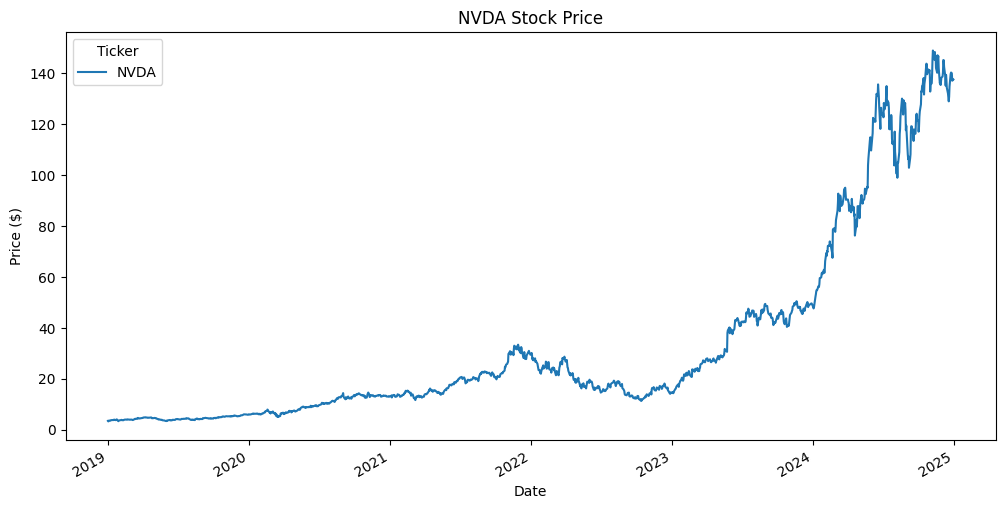

In [20]:
data['Close'].plot(figsize=(12,6), title=f"{ticker} Stock Price")
plt.ylabel('Price ($)')
plt.show()

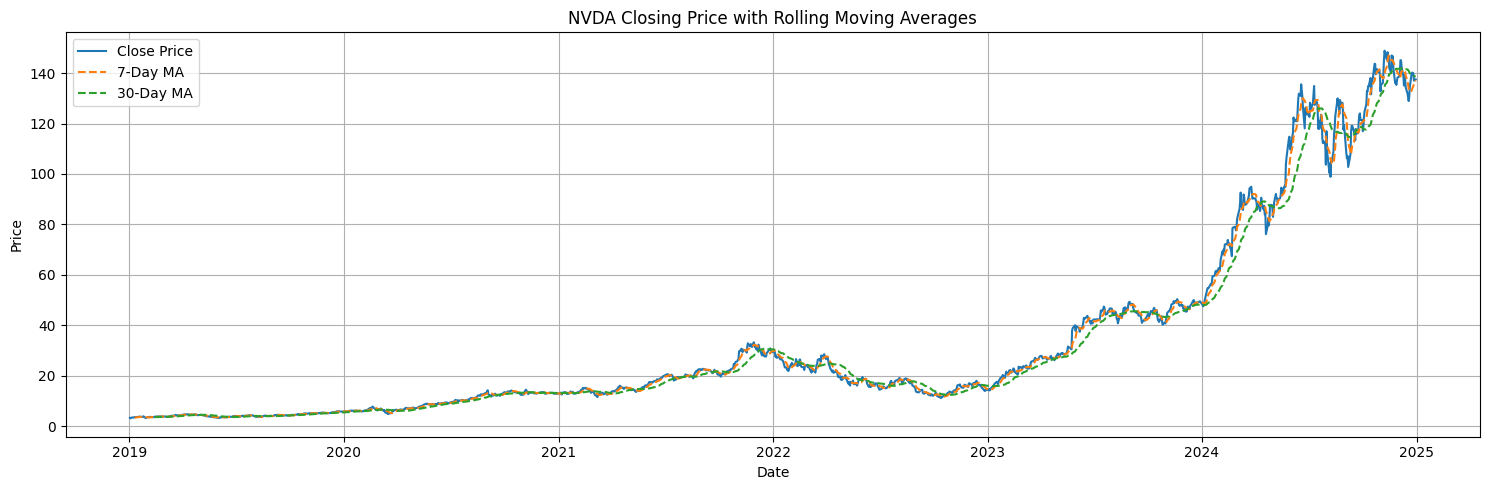

In [21]:
# Rolling averages
data['MA_7Day_Closing'] = data['Close'].rolling(window=7).mean()
data['MA_30Day_Closing'] = data['Close'].rolling(window=30).mean()

plt.figure(figsize=(15,5))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['MA_7Day_Closing'], label='7-Day MA', linestyle='--')
plt.plot(data['MA_30Day_Closing'], label='30-Day MA', linestyle='--')

plt.title('NVDA Closing Price with Rolling Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

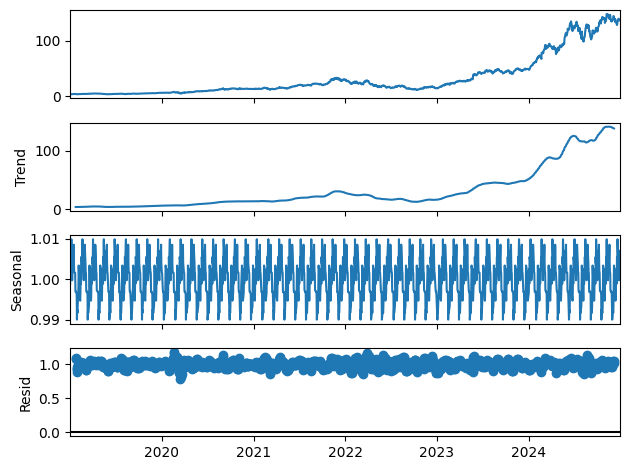

In [23]:
# Seasonal Multiplicative Decomposition
decomp = seasonal_decompose(data['Close'], model='multiplicative', period=30)
decomp.plot()
plt.show()

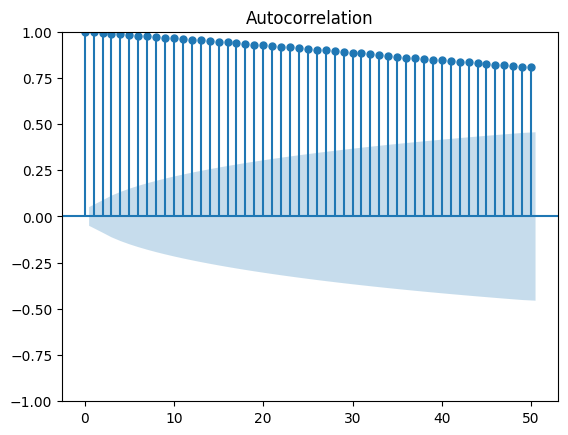

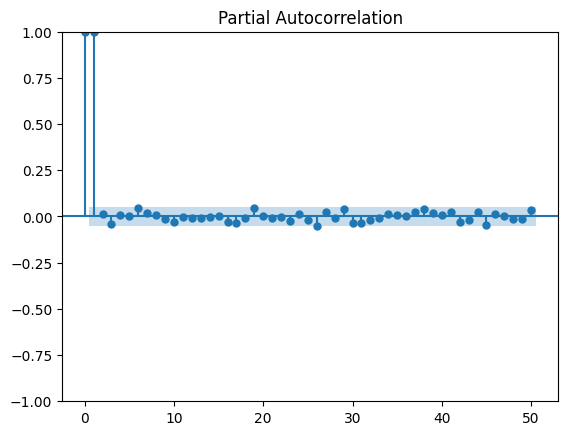

In [29]:
# ACF and PACF plots
plot_acf(data['Close'], lags=50)
plt.show()
plot_pacf(data['Close'], lags=50)
plt.show()

In [31]:
# Stationarity test
def check_stationarity(series):
  result = adfuller(series.dropna())
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])

check_stationarity(data['Close'])

ADF Statistic: 1.730036
p-value: 0.998200


Since p-value is greater than 0.5 then we need to apply differencing

In [32]:
# Differencing
data['Close_diff'] = data['Close'].diff()
check_stationarity(data['Close_diff'])

ADF Statistic: -7.111737
p-value: 0.000000


After 1st Order differencing p-value is now less than 0.5, therefore no further differencing required

# 2. ARIMA Benchmark

In [90]:
# Auto ARIMA to determine optimal (p,d,q) and non-seasonal parameters
model = auto_arima(
    data['Close'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=None, test='adf',
    seasonal=False,
    trace=True, suppress_warnings=True,
    stepwise=True
)
print("Non-seasonal Auto ARIMA Summary:")
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5589.745, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5601.399, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5596.782, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5597.572, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5604.367, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5590.726, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5590.727, Time=1.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5592.583, Time=0.91 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5591.709, Time=0.96 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5592.726, Time=3.46 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5593.204, Time=0.22 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 8.812 seconds
Non-seasonal Auto ARIMA Summary:
                               SARIMAX Results                                
Dep. Variable:                      y   No

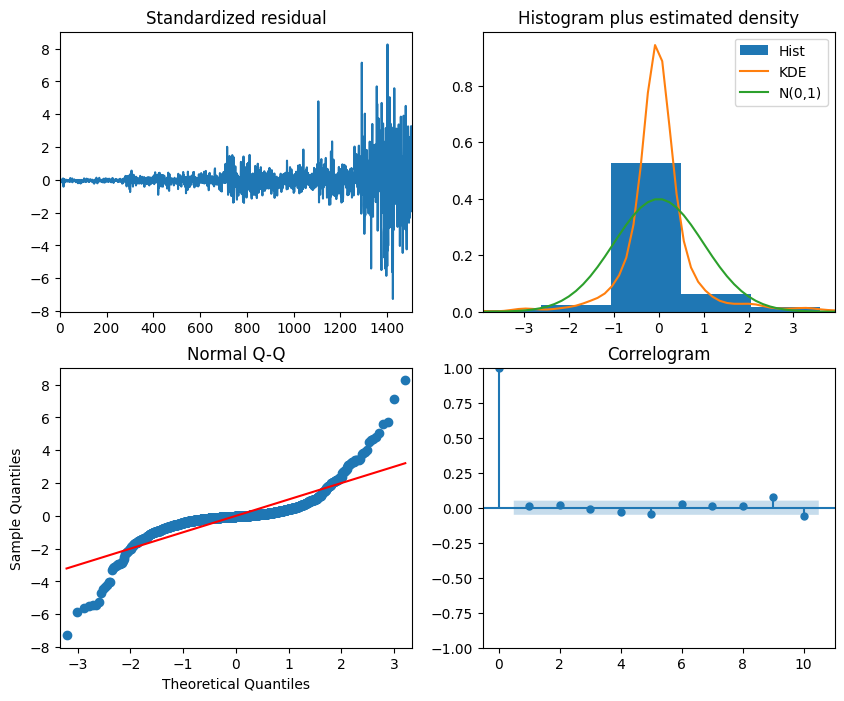

In [91]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

In [92]:
# Auto ARIMA to determine optimal (p,d,q) and seasonal parameters
smodel = auto_arima(
    data['Close'],
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=None, test='adf',
    seasonal=True, m=21,
    trace=True, suppress_warnings=True,
    stepwise=True
)

print("Auto SARIMA Summary:")
print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[21] intercept   : AIC=5585.777, Time=3.73 sec
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=5601.399, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[21] intercept   : AIC=5589.485, Time=1.71 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=5590.632, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[21]             : AIC=5604.367, Time=0.05 sec
 ARIMA(1,1,1)(0,0,1)[21] intercept   : AIC=5583.777, Time=4.78 sec
 ARIMA(1,1,1)(0,0,0)[21] intercept   : AIC=5589.745, Time=1.03 sec
 ARIMA(1,1,1)(0,0,2)[21] intercept   : AIC=5585.776, Time=15.65 sec
 ARIMA(1,1,1)(1,0,0)[21] intercept   : AIC=5583.773, Time=3.55 sec
 ARIMA(1,1,1)(2,0,0)[21] intercept   : AIC=5585.773, Time=13.61 sec
 ARIMA(1,1,1)(2,0,1)[21] intercept   : AIC=5587.588, Time=32.20 sec
 ARIMA(0,1,1)(1,0,0)[21] intercept   : AIC=5590.416, Time=1.70 sec
 ARIMA(2,1,1)(1,0,0)[21] intercept   : AIC=5584.885, Time=7.17 sec
 ARIMA(1,1,2)(1,0,0)[21] intercept   : AIC=5584.910, Time=4.76 sec
 ARIMA(0,1,0)(1,

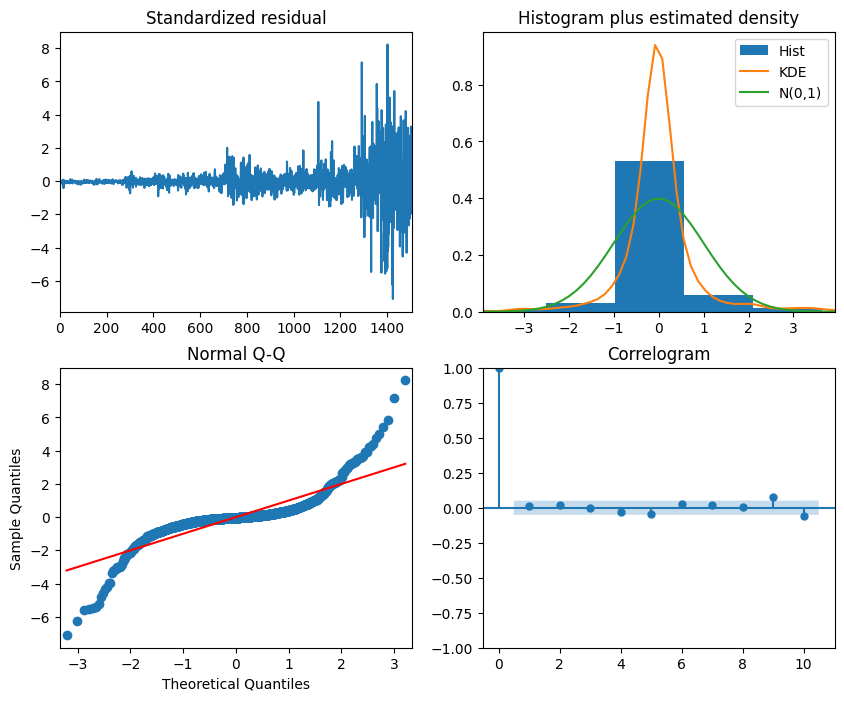

In [93]:
smodel.plot_diagnostics(figsize=(10,8))
plt.show()

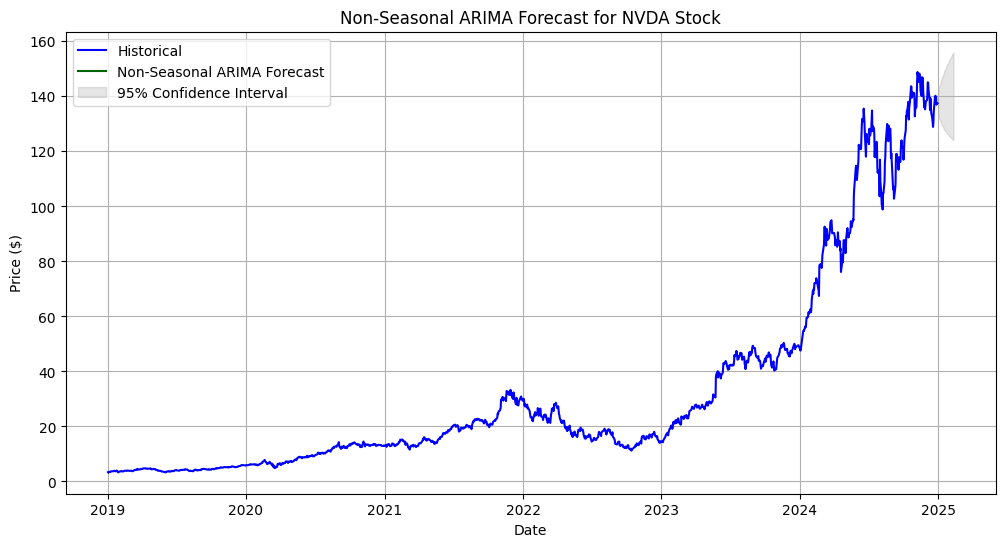

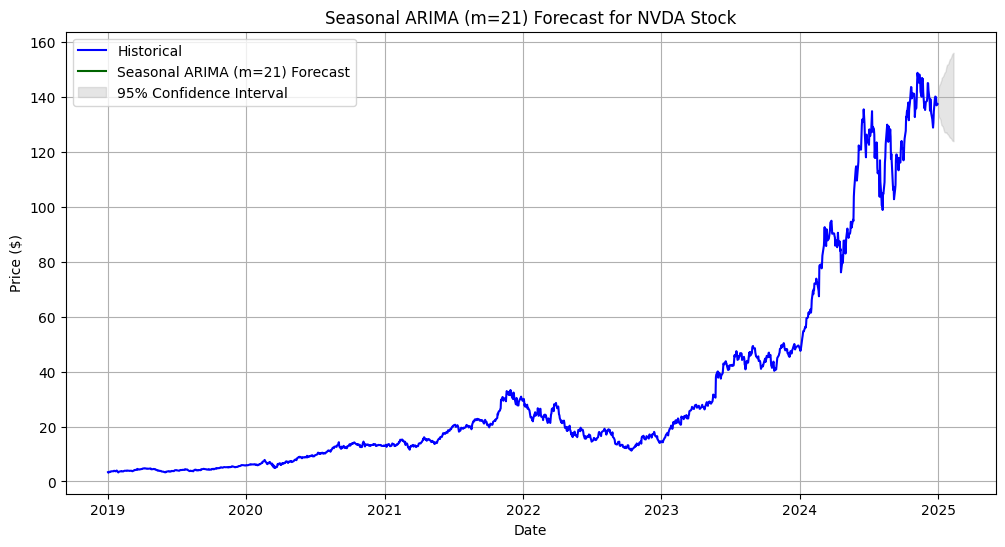

In [94]:

def plot_forecast(model, model_name, n_periods=30):
    forecast, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n_periods, freq='B')

    # Create series
    fitted_series = pd.Series(forecast, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(data['Close'], label='Historical', color='blue')
    plt.plot(fitted_series, label=f'{model_name} Forecast', color='darkgreen')
    plt.fill_between(index_of_fc, lower_series, upper_series, color='gray', alpha=0.2, label='95% Confidence Interval')

    plt.title(f"{model_name} Forecast for {ticker} Stock")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_forecast(model, "Non-Seasonal ARIMA")
plot_forecast(smodel, "Seasonal ARIMA (m=21)")

In [96]:
# Evaluation (on last 30 known days)
test = data['Close'].iloc[-30:]
# Predict the next 30 periods
pred = model.predict(n_periods=30, return_conf_int=False)

mae_arima = mean_absolute_error(test, pred)
rmse_arima = sqrt(mean_squared_error(test, pred))
print('ARIMA MAE:', mae_arima)
print('ARIMA RMSE:', rmse_arima)

ARIMA MAE: 3.98651689183846
ARIMA RMSE: 5.143197550288802


In [89]:
# Evaluation (on last 30 known days)
test = data['Close'].iloc[-30:]
# Predict the next 30 periods
pred = smodel.predict(n_periods=30, return_conf_int=False)

mae_sarima = mean_absolute_error(test, pred)
rmse_sarima = sqrt(mean_squared_error(test, pred))
print('SARIMA MAE:', mae_sarima)
print('SARIMA RMSE:', rmse_sarima)

SARIMA MAE: 3.995596009622264
SARIMA RMSE: 5.111266603700839


# 3. Deep Learning Forecasting with LSTM

In [69]:
# Prepare supervised data
dataset = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
dataset_scaled = scaler.fit_transform(dataset)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(dataset_scaled, seq_len)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [70]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(seq_len, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
history = lstm_model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)],
                    verbose=1)

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 6.0871e-05 - val_loss: 2.5678e-04
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.7606e-05 - val_loss: 2.5131e-04
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 5.3498e-05 - val_loss: 2.5635e-04
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.3869e-05 - val_loss: 2.4779e-04
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.9698e-05 - val_loss: 2.1493e-04
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.4324e-05 - val_loss: 2.3853e-04
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.5547e-05 - val_loss: 2.2850e-04
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.1029e-05 - val_loss: 2.3901e-04
Epoch 9/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.4218e-05 - val_loss: 2.1761e-04
Epoch 10/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.1274e-05 - val_loss: 2.3990e-04
Epoch 11/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.2847e-0

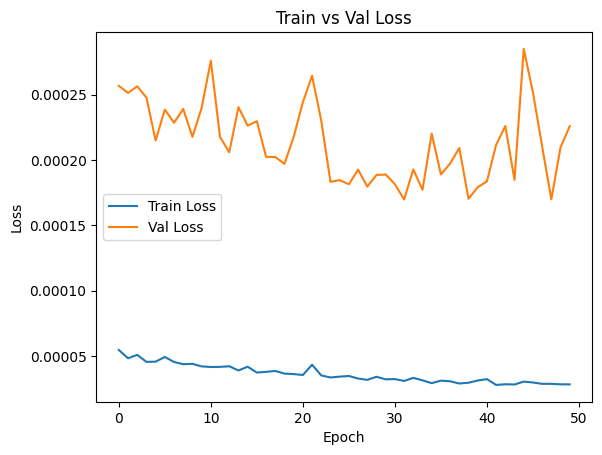

In [75]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Train vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [77]:
# Predict
y_pred = lstm_model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


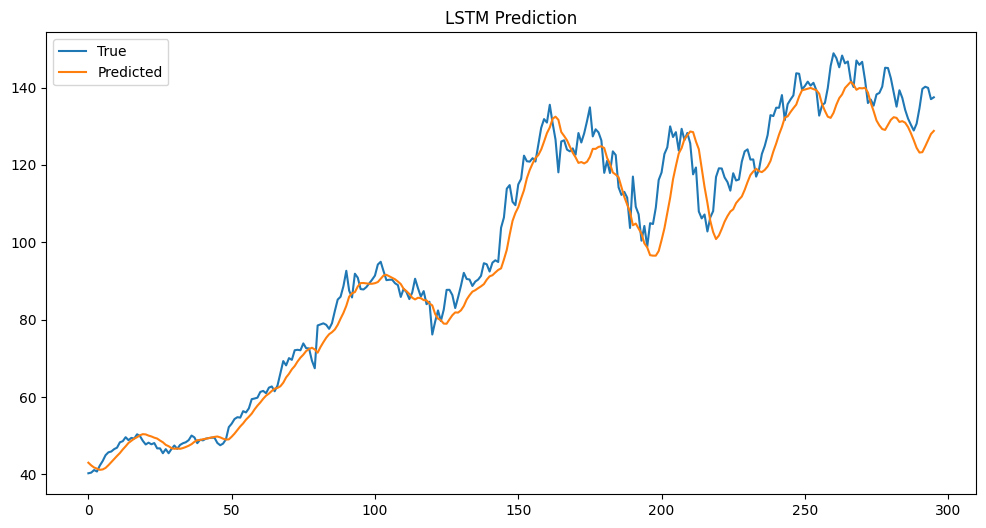

In [78]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='True')
plt.plot(y_pred_inv, label='Predicted')
plt.title('LSTM Prediction')
plt.legend()
plt.show()

In [97]:
# Evaluation
mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print('LSTM MAE:', mae_lstm)
print('LSTM RMSE:', rmse_lstm)

LSTM MAE: 4.54486794085116
LSTM RMSE: 6.242952982224604


In [99]:
# --- 5. COMPARISON AND REFLECTION ---

print("\nComparison Summary:")
print(f"ARIMA MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")
print(f"SARIMA MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")
print(f"LSTM MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")


Comparison Summary:
ARIMA MAE: 3.99, RMSE: 5.14
SARIMA MAE: 4.00, RMSE: 5.11
LSTM MAE: 4.54, RMSE: 6.24



**Interpretation:**

The ARIMA model slightly outperformed both SARIMA and LSTM in forecasting stock prices over the last 30 days.
It achieved the lowest MAE (3.99) and RMSE (5.14), indicating stronger predictive performance.
LSTM lagged slightly, with higher error values likely due to limited data or training complexity.

**Final Reflection:**

- ARIMA performed best overall.
- SARIMA showed no significant advantage, suggesting weak seasonality.
- LSTM was capable of learning complex patterns but underperformed due to its data and tuning sensitivity.
- For this dataset, ARIMA remains the preferred model.